# Dealing with missing data

In [1]:
import pandas as pd
from io import StringIO

from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
csv = \
"""A,B,C,D
1.0, 2.0, 3.0, 4.0
5.0, 6.0,, 8.0
10.0, 11.0, 12.0,
11.0,,,13.0
,,,
"""

df = pd.read_csv(StringIO(csv))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN
3,11.0,NaN,NaN,13.0
4,NaN,NaN,NaN,NaN


In [21]:
df.isnull().sum(axis=0)

A    1
B    2
C    3
D    2
dtype: int64

In [22]:
df.isnull().sum(axis=1)

0    0
1    1
2    1
3    2
4    4
dtype: int64

In [23]:
df.dropna(axis=0) # rows

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [30]:
df.dropna(axis=1, thresh=3) # columns that have at least 3 not NaN values

,A,B,D
0,1.0,2.0,4.0
1,5.0,6.0,8.0
2,10.0,11.0,NaN
3,11.0,NaN,13.0
4,NaN,NaN,NaN


In [18]:
df.dropna(how='all', axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [32]:
df.dropna(subset=['C']) # drop rows with NaN at column C

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


## Imputing missing values

In [33]:
from sklearn.preprocessing import Imputer

In [39]:
i_mean = Imputer(missing_values='NaN', strategy='mean', axis=0) # aggregate at axis = 0(rows)
i_median = Imputer(strategy='median') # missing_values='NaN' and axis=0 - default values
i_most_freq = Imputer(strategy='most_frequent') # missing_values='NaN' and axis=0 - default values

df_mean = i_mean.fit_transform(df.values)
df_median = i_median.fit_transform(df.values)
df_most_freq = i_most_freq.fit_transform(df.values)

df_mean

array([[  1.        ,   2.        ,   3.        ,   4.        ],
       [  5.        ,   6.        ,   7.5       ,   8.        ],
       [ 10.        ,  11.        ,  12.        ,   8.33333333],
       [ 11.        ,   6.33333333,   7.5       ,  13.        ],
       [  6.75      ,   6.33333333,   7.5       ,   8.33333333]])

In [36]:
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  11.,  12.,  nan],
       [ 11.,  nan,  nan,  13.],
       [ nan,  nan,  nan,  nan]])

In [40]:
i_mean.statistics_, i_median.statistics_, i_most_freq.statistics_

(array([ 6.75      ,  6.33333333,  7.5       ,  8.33333333]),
 array([ 7.5,  6. ,  7.5,  8. ]),
 array([ 1.,  2.,  3.,  4.]))

## Handling categorical data

In [68]:
df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']], columns=['color', 'size', 'price', 'classlabel'])

df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### Mapping ordinal features

In [48]:
size_mapping = {'XL':3, 'L':2, 'M':1}
inv_size_mapping = {v:k for k,v in size_mapping.items()}

df['sizeOrd'] = df['size'].map(size_mapping)

df

,color,size,price,classlabel,sizeOrd
0,green,M,10.1,class1,1
1,red,L,13.5,class2,2
2,blue,XL,15.3,class1,3


In [49]:
df['sizeOrd'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: sizeOrd, dtype: object

### Encoding class labels

In [56]:
class_mapping = {label:ix for ix, label in enumerate(df.classlabel.unique())}
inv_class_mapping = {v:k for k,v in class_mapping.items()}

In [53]:
class_mapping

{'class1': 0, 'class2': 1}

In [55]:
df['classlabelEnc'] = df.classlabel.map(class_mapping)

df

,color,size,price,classlabel,sizeOrd,classlabelEnc
0,green,M,10.1,class1,1,0
1,red,L,13.5,class2,2,1
2,blue,XL,15.3,class1,3,0


In [58]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder().fit(df.classlabel.values)

y = class_le.transform(df.classlabel.values)

y

array([0, 1, 0])

In [59]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### Performing one-hot encoding on nominal features

In [62]:
X = df[['color', 'sizeOrd', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])

X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [63]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])

ohe.fit_transform(X).toarray()

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

In [65]:
pd.get_dummies(df[['color', 'sizeOrd', 'price']])

,sizeOrd,price,color_blue,color_green,color_red
0,1,10.1,0.0,1.0,0.0
1,2,13.5,0.0,0.0,1.0
2,3,15.3,1.0,0.0,0.0


## Partitioning a dataset in training and test sets

In [69]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [70]:
df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
              'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanine',
              'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

In [72]:
df['Class label'].unique()

array([1, 2, 3])

In [73]:
df.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanine,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [75]:
from sklearn.cross_validation import train_test_split

X, y = df.iloc[:, 1:], df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

## Bringing features onto the same scale

### MinMaxScaler

In [83]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

mms = MinMaxScaler()

X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

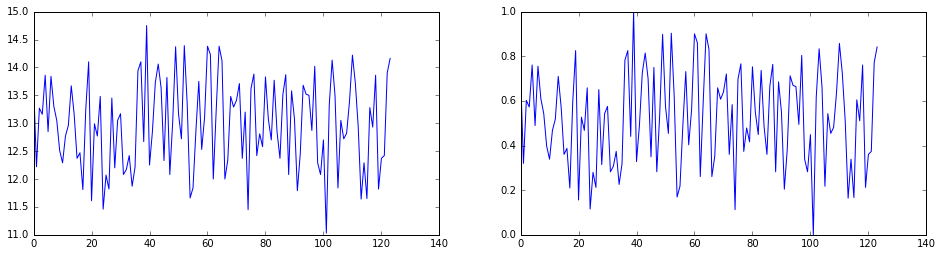

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(np.arange(0, X_train.shape[0], 1), X_train.iloc[:, 0])
ax2.plot(np.arange(0, X_train_norm.shape[0], 1), X_train_norm[:, 0])

### StandardScaler

In [109]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

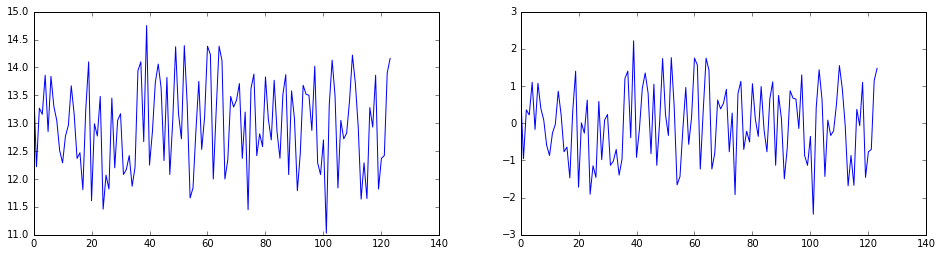

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(np.arange(0, X_train.shape[0], 1), X_train.iloc[:, 0])
ax2.plot(np.arange(0, X_train_std.shape[0], 1), X_train_std[:, 0])

In [111]:
hh = MinMaxScaler()

X_train_std_norm = hh.fit_transform(X_train_std)

(20, 30)

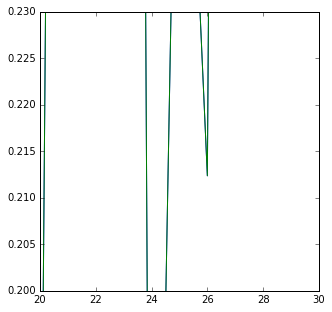

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(np.arange(0, X_train_std_norm.shape[0], 1), X_train_std_norm[:, 0])
ax.plot(np.arange(0, X_train_norm.shape[0], 1), X_train_norm[:, 0])

ax.set_ylim([.2, .23])
ax.set_xlim([20, 30])

In [ ]:
# qual a relação entre MinMaxScaler e StandardScaler no 'formato' da função?